In [86]:
import pandas as pd

In [87]:
df = pd.read_csv(r"C:\Users\ahlam\Desktop\master_c_t_p\Techniques_sélection_évaluation_modèles\tp\league_data.csv");
print("the number of observations and the number of features in the dataset", df.shape);

the number of observations and the number of features in the dataset (461, 17)


In [88]:
missing_values = df.isnull().sum()
print(missing_values)

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_value       0
fpl_sel         0
fpl_points      0
region          1
nationality     0
new_foreign     0
age_cat         0
club_id         0
big_club        0
new_signing     0
dtype: int64


In [89]:
missing_region_player = df[df["region"].isnull()]
print("missing_region_player:")
display(missing_region_player)
df_cleaned = df.dropna(subset=['region'])
missing_region_player_values = df_cleaned['region'].isnull().sum()
print("missing_region_player_values:", missing_region_player_values)
print("df_cleaned:", df_cleaned.shape);

missing_region_player:


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
188,Steve Mounie,Huddersfield,22,CF,1,5.5,56,6.0,0.60%,0,NaN,Benin,0,2,8,0,0


missing_region_player_values: 0
df_cleaned: (460, 17)


In [126]:
Top_6_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham']
df_cleaned.loc[:, "big_clubs"] = df_cleaned["club"].apply(lambda x: 1 if x in Top_6_clubs else 0)
print("displays dataset after update")
display(df_cleaned[["club", "big_clubs"]].head(10))
print("check distribution of values in big_clubs :")
print(df_cleaned["big_clubs"].value_counts())

displays dataset after update


,club,big_clubs
0,Arsenal,1
1,Arsenal,1
2,Arsenal,1
3,Arsenal,1
4,Arsenal,1
5,Arsenal,1
6,Arsenal,1
7,Arsenal,1
8,Arsenal,1
9,Arsenal,1


check distribution of values in big_clubs :
big_clubs
0    365
1     95
Name: count, dtype: int64


In [91]:
bins = [16, 21, 24, 27, 31, 33, 38]  
labels = [1, 2, 3, 4, 5, 6]  
df_cleaned.loc[:, "age_cat"] = pd.cut(df_cleaned["age"], bins=bins, labels=labels)
age_categories = df_cleaned.groupby('age_cat', observed=True).agg(min_age=('age', 'min'), max_age=('age', 'max'))
display(age_categories) 

,min_age,max_age
age_cat,,
1,17,21
2,22,24
3,25,27
4,28,31
5,32,33
6,34,38


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

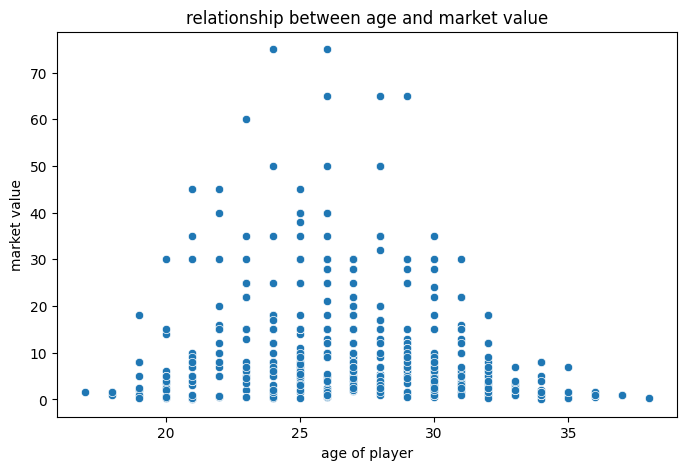

In [93]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_cleaned, x="age", y="market_value")
plt.xlabel("age of player")
plt.ylabel("market value")
plt.title("relationship between age and market value")
plt.show()

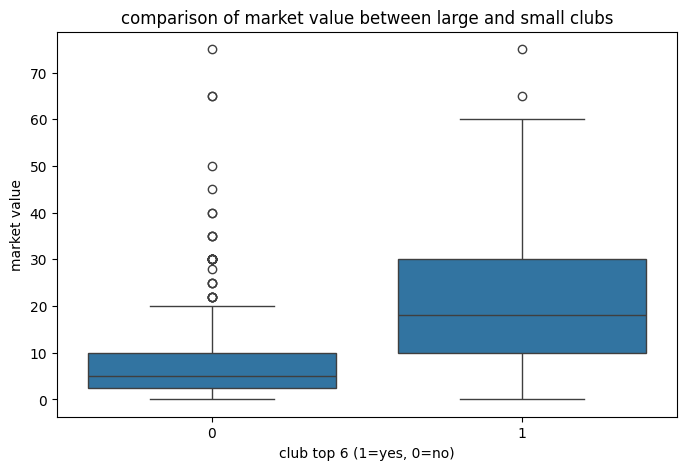

In [94]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cleaned, x="big_clubs", y="market_value")
plt.xlabel("club top 6 (1=yes, 0=no)")
plt.ylabel("market value")
plt.title("comparison of market value between large and small clubs")
plt.show()

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X = df_cleaned.drop(columns=["market_value"]) 
y = df_cleaned["market_value"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_cleaned["region"])
print("Training set size :", X_train.shape)
print("Test set size :", X_test.shape)

Training set size : (368, 17)
Test set size : (92, 17)


In [97]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

In [98]:
categorical_cols = ["club", "position", "nationality", "region", "age_cat", "big_clubs"] 
numerical_cols = ["age", "fpl_points", "page_views", "fpl_value"] 

categorical_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore') 
numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),])
preprocessor = ColumnTransformer([('cat', categorical_encoder, categorical_cols), ('num', numerical_pipe, numerical_cols)])
lr = LinearRegression()
model = Pipeline([('preprocessor', preprocessor),('regressor', lr)])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['club', 'position',
                                                   'nationality', 'region',
                                                   'age_cat', 'big_clubs']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'fpl_points',
                                                   'page_views',
                                                   'fpl_value'])])),
                ('regressor', LinearRegression())])

In [99]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [100]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"root mean squared error (RMSE) : {rmse:.2f}")
print(f"coefficient of determination (R²) : {r2:.2f}")

root mean squared error (RMSE) : 6.35
coefficient of determination (R²) : 0.75


C:\Users\ahlam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


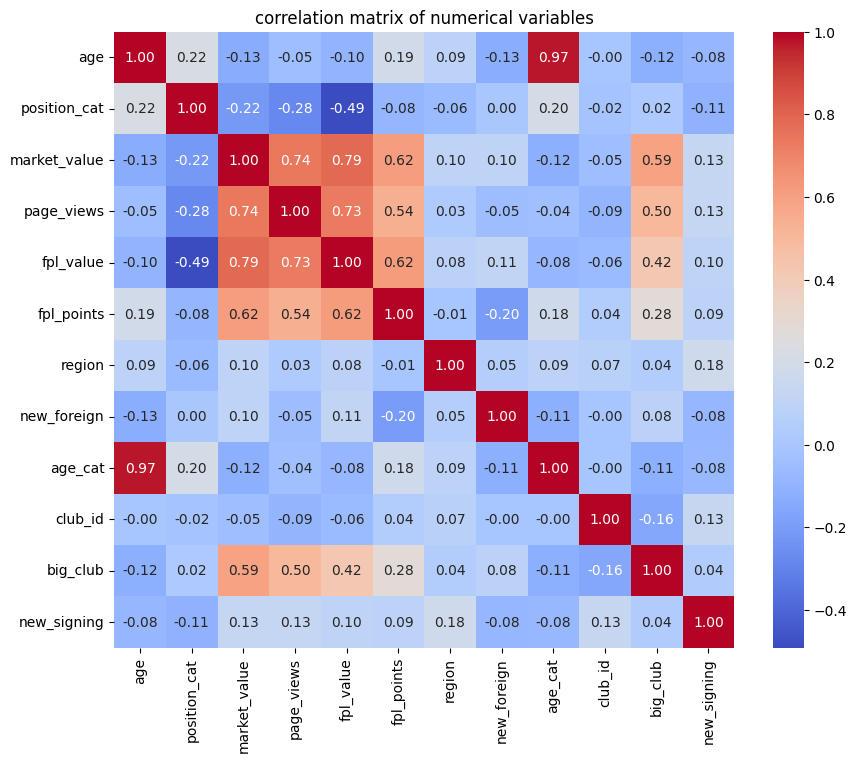

top 3 variables most correlated with 'market_value':
fpl_value     0.788653
page_views    0.739657
fpl_points    0.615155
Name: market_value, dtype: float64

variables selected for linear regression: ['fpl_value', 'page_views', 'fpl_points']
root mean squared error (RMSE) : 6.21
coefficient of determination (R²) : 0.67


In [101]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("correlation matrix of numerical variables")
plt.show()

corr_with_target = correlation_matrix['market_value'].drop('market_value')  
top_3_variables = corr_with_target.abs().sort_values(ascending=False).head(3)  
print("top 3 variables most correlated with 'market_value':")
print(top_3_variables)
selected_features = top_3_variables.index.tolist()
print("\nvariables selected for linear regression:", selected_features)

X = df[selected_features] 
y = df['market_value']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"root mean squared error (RMSE) : {rmse:.2f}")
print(f"coefficient of determination (R²) : {r2:.2f}")

In [124]:
df_cleaned["age_squared"] = df_cleaned["age"] ** 2
df_cleaned["page_views_fpl"] = df_cleaned["page_views"] * df_cleaned["fpl_points"]
features = ["fpl_points", "age", "age_squared", "new_signing", "big_clubs", "position_cat", "age_cat", "page_views_fpl"]
X = df_cleaned[features]
y = df_cleaned["market_value"]
X_train_client, X_test_client, y_train_client, y_test_client = train_test_split(X, y, test_size=0.3, random_state=42)

model_client = LinearRegression()
model_client.fit(X_train_client, y_train_client)
y_pred_client = model_client.predict(X_test_client)
rmse_client = np.sqrt(mean_squared_error(y_test_client, y_pred_client))
r2_client = r2_score(y_test_client, y_pred_client)

print(f"root mean squared error (RMSE) : {rmse_client:.2f}")
print(f"coefficient of determination (R²) : {r2_client:.2f}")

root mean squared error (RMSE) : 6.46
coefficient of determination (R²) : 0.72


In [125]:
beta_8 = model_proposed.coef_[features.index("page_views_fpl")]
fpl_points_mean = df_cleaned["fpl_points"].mean()
delta_page_views = 10 / (beta_8 * fpl_points_mean)
print(f"number of page views needed to increase market value by 10 units : {delta_page_views:.2f}")

number of page views needed to increase market value by 10 units : 3465.15


In [74]:
client_model = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
client_model.fit(X_train, y_train)
y_pred_client = client_model.predict(X_test)
mse_client = mean_squared_error(y_test, y_pred_client)
rmse_client = np.sqrt(mse_client)
r2_client = r2_score(y_test, y_pred_client)
print(f"RMSE of my model : {rmse:.2f}")
print(f"R² of my model : {r2:.2f}")

print(f"\nRMSE of the model proposed by the customer : {rmse_client:.2f}")
print(f"R² of the model proposed by the customer : {r2_client:.2f}")

RMSE of my model : 6.23
R² of my model : 0.77

RMSE of the model proposed by the customer : 6.23
R² of the model proposed by the customer : 0.77


C:\Users\ahlam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [55]:
#exo2

In [25]:
df = pd.read_csv(r"C:\Users\ahlam\Desktop\master_c_t_p\Techniques_sélection_évaluation_modèles\tp\shortleaf.txt", sep="\t")
print(df.head())

   Diam  Vol
0   4.4  2.0
1   4.6  2.2
2   5.0  3.0
3   5.1  4.3
4   5.1  3.0


In [26]:
X = df['Diam'].values.reshape(-1, 1)
y = df['Vol'].values
model = LinearRegression()
model.fit(X, y)
a = model.coef_[0]
b = model.intercept_

print(f"Value of a (slope) : {a:.4f}")
print(f"Value of b (intercept) : {b:.4f}")

Value of a (slope) : 6.8367
Value of b (intercept) : -41.5681


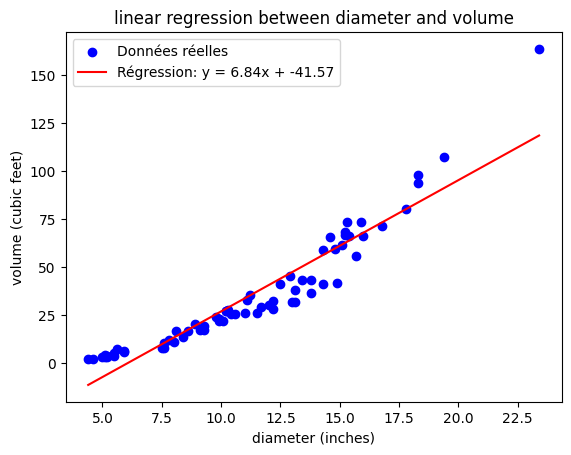

In [27]:
y_pred = model.predict(X)
plt.scatter(df['Diam'], df['Vol'], color='blue', label='Données réelles')
plt.plot(df['Diam'], y_pred, color='red', label=f'Régression: y = {a:.2f}x + {b:.2f}')
plt.xlabel('diameter (inches)')
plt.ylabel('volume (cubic feet)')
plt.title('linear regression between diameter and volume')
plt.legend()
plt.show()

In [112]:
df['log_Diam'] = np.log(df['Diam'])
X_log = df['log_Diam'].values.reshape(-1, 1)
y = df['Vol'].values
model_log = LinearRegression()
model_log.fit(X_log, y)
a_log = model_log.coef_[0]
b_log = model_log.intercept_

print(f"Value of a : {a_log:.4f}")
print(f"Value of b : {b_log:.4f}")

Value of a : 64.5358
Value of b : -116.1618


In [113]:
df['log_Vol'] = np.log(df['Vol'])
X_log = df['log_Diam'].values.reshape(-1, 1)
y_log = df['log_Vol'].values
model_log_vol = LinearRegression()
model_log_vol.fit(X_log, y_log)
a_log_vol = model_log_vol.coef_[0]
b_log_vol = model_log_vol.intercept_

print(f"Valeur de a : {a_log_vol:.4f}")
print(f"Valeur de b : {b_log_vol:.4f}")

Valeur de a : 2.5644
Valeur de b : -2.8718


In [114]:
y_pred = model.predict(X)
y_pred_log = model_log.predict(X_log)
y_pred_log_vol = model_log_vol.predict(X_log)

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
r2_log = r2_score(y, y_pred_log)

rmse_log_vol = np.sqrt(mean_squared_error(y_log, y_pred_log_vol))
r2_log_vol = r2_score(y_log, y_pred_log_vol)

print(f"linear regression model (diam vs vol) :")
print(f"RMSE : {rmse:.2f}, R² : {r2:.2f}")
print(f"\nlinear regression model (vol vs log(diam)) :")
print(f"RMSE : {rmse_log:.2f}, R² : {r2_log:.2f}")
print(f"\nlinear regression model (log(vol) vs log(diam)) :")
print(f"RMSE : {rmse_log_vol:.2f}, R² : {r2_log_vol:.2f}")

linear regression model (diam vs vol) :
RMSE : 9.73, R² : 0.89

linear regression model (vol vs log(diam)) :
RMSE : 14.95, R² : 0.75

linear regression model (log(vol) vs log(diam)) :
RMSE : 0.17, R² : 0.97


In [118]:
#exo3

In [120]:
from sklearn.datasets import load_digits

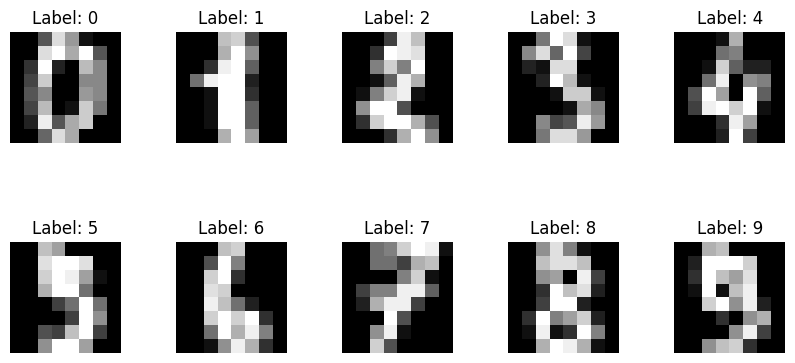

In [126]:
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in np.arange(10):
    axes[i].imshow(digits.images[i], cmap='gray')  
    axes[i].set_title(f"Label: {digits.target[i]}") 
    axes[i].axis('off')  

plt.subplots_adjust(wspace=0.5) 
plt.show()

In [127]:
unique, counts = np.unique(y_digits, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:")
print(class_distribution)

Class distribution:
{0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


In [123]:
from sklearn.decomposition import PCA

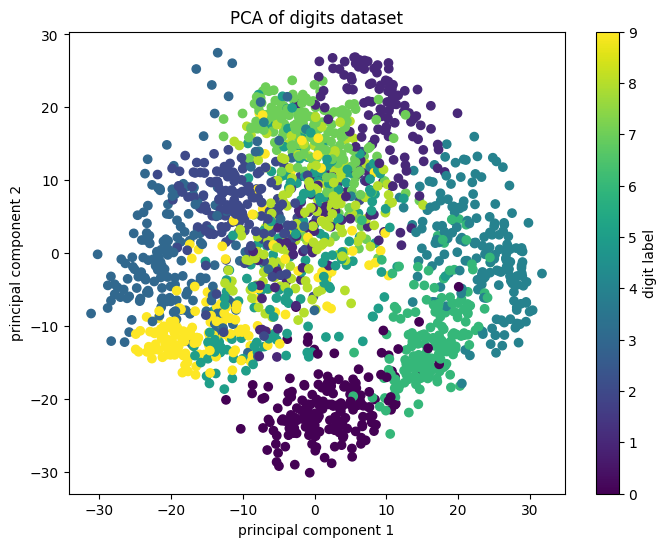

In [136]:
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

pca = PCA(n_components=2)
X_digits_pca = pca.fit_transform(X_digits)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_digits_pca[:, 0], X_digits_pca[:, 1], c=y_digits, cmap='viridis', label='Digits')
plt.colorbar(scatter, label='digit label')
plt.title("PCA of digits dataset")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.show()

In [137]:
digits = load_digits()
X_digits = digits.data  
y_digits = digits.target  
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

print("training set size:", X_train.shape)
print("test set size:", X_test.shape)

training set size: (1437, 64)
test set size: (360, 64)


In [131]:
from sklearn.ensemble import RandomForestClassifier

In [138]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
print(f"training accuracy: {train_accuracy:.4f}")

test_accuracy = clf.score(X_test, y_test)
print(f"test accuracy: {test_accuracy:.4f}")

training accuracy: 1.0000
test accuracy: 0.9722


In [134]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [140]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"accuracy: {accuracy:.4f}")
print(f"precision (macro): {precision_macro:.4f}")
print(f"recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"precision (micro): {precision_micro:.4f}")
print(f"recall (micro): {recall_micro:.4f}")
print(f"F1-score (micro): {f1_micro:.4f}")

accuracy: 0.9722
precision (macro): 0.9740
recall (macro): 0.9727
F1-score (macro): 0.9732
precision (micro): 0.9722
recall (micro): 0.9722
F1-score (micro): 0.9722
